GPflow with TensorFlow 2
===

##### Small steps big changes

<br>



In [1]:
from typing import Tuple, Optional
from pathlib import Path

import datetime
import io
import matplotlib.pyplot as plt

import numpy as np
import tensorflow as tf
import gpflow

from gpflow.config import default_float

import warnings

warnings.filterwarnings('ignore')

Make `tensorboard` work inside notebook:

In [2]:
output_logdir = "/tmp/tensorboard"

!rm -rf "{output_logdir}"
!mkdir "{output_logdir}"

%load_ext tensorboard
%matplotlib inline


def enumerated_logdir(_logdir_id: int = [0]):
    logdir = Path(output_logdir, str(_logdir_id[0]))
    _logdir_id[0] += 1
    return str(logdir)

Set up random seeds and default float for `gpflow` tensors:

In [3]:
gpflow.config.set_default_float(np.float64)
np.random.seed(0)
tf.random.set_seed(0)

## Loading data using TensorFlow Datasets

For this example, we create a synthetic dataset (noisy sine function):

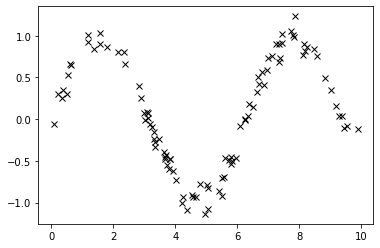

In [4]:
def noisy_sin(x):
    return tf.math.sin(x) + 0.1 * tf.random.normal(x.shape, dtype=default_float())

num_train_data, num_test_data = 100, 500

X = tf.random.uniform((num_train_data, 1), dtype=default_float()) * 10
Xtest = tf.random.uniform((num_test_data, 1), dtype=default_float()) * 10

Y = noisy_sin(X)
Ytest = noisy_sin(Xtest)

data = (X, Y)

plt.plot(X, Y, 'xk')
plt.show()

Working with TensorFlow Datasets is an efficient way to rapidly shuffle, iterate, and batch from data.

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((X, Y))
test_dataset = tf.data.Dataset.from_tensor_slices((Xtest, Ytest))

batch_size = 32
num_features = 10
prefetch_size = num_train_data // 2
shuffle_buffer_size = num_train_data // 2
num_batches_per_epoch = num_train_data // batch_size

original_train_dataset = train_dataset
train_dataset = train_dataset.repeat()\
                    .prefetch(prefetch_size)\
                    .shuffle(buffer_size=shuffle_buffer_size)\
                    .batch(batch_size)

print(f"prefetch_size={prefetch_size}")
print(f"shuffle_buffer_size={shuffle_buffer_size}")
print(f"num_batches_per_epoch={num_batches_per_epoch}")

prefetch_size=50
shuffle_buffer_size=50
num_batches_per_epoch=3


## Define a GP model

In GPflow 2.0, we use `tf.Module` (or the very thin `gpflow.base.Module` wrapper) to build all our models, as well as their components (kernels, likelihoods, parameters, and so on).

In [6]:
kernel = gpflow.kernels.SquaredExponential(variance=2.)
likelihood = gpflow.likelihoods.Gaussian()
inducing_variable = np.linspace(0, 10, num_features).reshape(-1, 1)

model = gpflow.models.SVGP(kernel=kernel, likelihood=likelihood, inducing_variable=inducing_variable)

You can set a module (or a particular parameter) to be non-trainable using the auxiliary method ```set_trainable(module, False)```:

In [7]:
from gpflow.utilities import set_trainable

set_trainable(likelihood, False)
set_trainable(kernel.variance, False)

set_trainable(likelihood, True)
set_trainable(kernel.variance, True)

We can use ```param.assign(value)``` to assign a value to a parameter:

In [8]:
kernel.lengthscale.assign(0.5)

<tf.Variable 'UnreadVariable' shape=() dtype=float64, numpy=-0.43275212956718856>

All these changes are reflected when we use ```print_summary(model)``` to print a detailed summary of the model. By default the output is displayed in a minimalistic and simple table.

In [9]:
from gpflow.utilities import print_summary

print_summary(model)  # same as print_summary(model, fmt="simple")

name                      class      transform         prior    trainable    shape        dtype    value
------------------------  ---------  ----------------  -------  -----------  -----------  -------  ------------------
SVGP.kernel.variance      Parameter  Softplus                   True         ()           float64  2.0
SVGP.kernel.lengthscale   Parameter  Softplus                   True         ()           float64  0.5
SVGP.likelihood.variance  Parameter  Softplus + Shift           True         ()           float64  0.9999999999999999
SVGP.inducing_variable.Z  Parameter                             True         (10, 1)      float64  [[0....
SVGP.q_mu                 Parameter                             True         (10, 1)      float64  [[0....
SVGP.q_sqrt               Parameter  FillTriangular             True         (1, 10, 10)  float64  [[[1., 0., 0....


We can change default printing so that it will look nicer in our notebook:

In [10]:
gpflow.config.set_default_summary_fmt("notebook")

print_summary(model)  # same as print_summary(model, fmt="notebook")

Jupyter notebooks also format GPflow classes (that are subclasses of `gpflow.base.Module`) in the same nice way when at the end of a cell (this is independent of the `default_summary_fmt`):

In [11]:
model

name                      class      transform         prior    trainable    shape        dtype    value
------------------------  ---------  ----------------  -------  -----------  -----------  -------  ------------------
SVGP.kernel.variance      Parameter  Softplus                   True         ()           float64  2.0
SVGP.kernel.lengthscale   Parameter  Softplus                   True         ()           float64  0.5
SVGP.likelihood.variance  Parameter  Softplus + Shift           True         ()           float64  0.9999999999999999
SVGP.inducing_variable.Z  Parameter                             True         (10, 1)      float64  [[0....
SVGP.q_mu                 Parameter                             True         (10, 1)      float64  [[0....
SVGP.q_sqrt               Parameter  FillTriangular             True         (1, 10, 10)  float64  [[[1., 0., 0....

## Training using Gradient Tapes

In TensorFlow 2, we can optimize (trainable) model parameters with TensorFlow optimizers using `tf.GradientTape`. In this simple example, we perform one gradient update of the Adam optimizer to minimize the negative marginal log likelihood (or ELBO) of our model.

In [12]:
optimizer = tf.optimizers.Adam()

with tf.GradientTape() as tape:
    tape.watch(model.trainable_variables)
    obj = - model.elbo(data)
    grads = tape.gradient(obj, model.trainable_variables)

optimizer.apply_gradients(zip(grads, model.trainable_variables))

<tf.Variable 'UnreadVariable' shape=() dtype=int64, numpy=1>

For a more elaborate example of a gradient update we can define an ```optimization_step``` that uses the decorator ```tf.function``` on a closure. A closure is a callable that returns the model objective evaluated at a given dataset when called.

In [13]:
def optimization_step(model: gpflow.models.SVGP, batch: Tuple[tf.Tensor, tf.Tensor]):
    with tf.GradientTape(watch_accessed_variables=False) as tape:
        tape.watch(model.trainable_variables)
        obj = - model.elbo(batch)
        grads = tape.gradient(obj, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))

We can use the functionality of TensorFlow Datasets to define a simple training loop that iterates over batches of the training dataset:

In [14]:
def simple_training_loop(model: gpflow.models.SVGP, epochs: int = 1, logging_epoch_freq: int = 10):
    batches = iter(train_dataset)
    tf_optimization_step = tf.function(optimization_step, autograph=False)
    for epoch in range(epochs):
        for _ in range(num_batches_per_epoch):
            tf_optimization_step(model, next(batches))

        epoch_id = epoch + 1
        if epoch_id % logging_epoch_freq == 0:
            tf.print(f"Epoch {epoch_id}: ELBO (train) {model.elbo(data)}")

In [15]:
simple_training_loop(model, epochs=10, logging_epoch_freq=2)

Epoch 2: ELBO (train) -210.8625120744022


Epoch 4: ELBO (train) -209.2089265188789


Epoch 6: ELBO (train) -207.5394336278164


Epoch 8: ELBO (train) -205.86180225764397


Epoch 10: ELBO (train) -204.17336161825466


## Monitoring

We can monitor the training procedure using `tf.summary`. First we create a summary writer object through which we can write scalars and images.

In [16]:
from intro_to_gpflow2_plotting import plotting_regression, summary_matplotlib_image

samples_input = tf.cast(np.linspace(0, 10, 100).reshape(100, 1), default_float())

def monitored_training_loop(model: gpflow.models.SVGP, logdir: str,
                            epochs: int = 1, logging_epoch_freq: int = 10,
                            num_samples: int = 10):
    summary_writer = tf.summary.create_file_writer(logdir)
    tf_optimization_step = tf.function(optimization_step)
    batches = iter(train_dataset)

    with summary_writer.as_default():
        for epoch in range(epochs):
            for _ in range(num_batches_per_epoch):
                tf_optimization_step(model, next(batches))

            epoch_id = epoch + 1
            if epoch_id % logging_epoch_freq == 0:
                tf.print(f"Epoch {epoch_id}: ELBO (train) {model.elbo(data)}")

                mean, var = model.predict_f(samples_input)
                samples = model.predict_f_samples(samples_input, num_samples)
                fig = plotting_regression(X, Y, samples_input, mean, var, samples)

                summary_matplotlib_image(dict(model_samples=fig), step=epoch)
                tf.summary.scalar('elbo', data=model.elbo(data), step=epoch)
                tf.summary.scalar('likelihood/variance', data=model.likelihood.variance, step=epoch)
                tf.summary.scalar('kernel/lengthscale', data=model.kernel.lengthscale, step=epoch)
                tf.summary.scalar('kernel/variance', data=model.kernel.variance, step=epoch)

In [17]:
model = gpflow.models.SVGP(kernel=kernel, likelihood=likelihood, inducing_variable=inducing_variable)

output_logdir = enumerated_logdir()
monitored_training_loop(model, output_logdir, epochs=1000, logging_epoch_freq=100)

Epoch 100: ELBO (train) -141.17663846231952


Epoch 200: ELBO (train) -115.73096230500155


Epoch 300: ELBO (train) -99.34845106168397


Epoch 400: ELBO (train) -84.81538381607197


Epoch 500: ELBO (train) -70.5410653853418


Epoch 600: ELBO (train) -56.266405542025005


Epoch 700: ELBO (train) -42.13877491952342


Epoch 800: ELBO (train) -28.37536382146062


Epoch 900: ELBO (train) -15.138323262094682


Epoch 1000: ELBO (train) -2.6051236238069606


Then, we can use TensorBoard to examine the training procedure in more detail

In [18]:
# %tensorboard --logdir "{output_logdir}"

## Checkpointing: saving and loading models

With the help of `tf.train.CheckpointManager` and `tf.train.Checkpoint`, we can checkpoint the model throughout the training procedure. Let's start with a simple example using checkpointing to save and load a `tf.Variable`:

In [19]:
initial_value = 1.2
a = tf.Variable(initial_value)

Create `Checkpoint` object:

In [20]:
ckpt = tf.train.Checkpoint(a=a)
manager = tf.train.CheckpointManager(ckpt, output_logdir, max_to_keep=3)

Save the variable `a` and change its value right after:

In [21]:
manager.save()
_ = a.assign(0.33)

Now we can restore the old variable value:

In [22]:
print(f"Current value of variable a: {a.numpy():0.3f}")

ckpt.restore(manager.latest_checkpoint)

print(f"Value of variable a after restore: {a.numpy():0.3f}")

Current value of variable a: 0.330
Value of variable a after restore: 1.200


In the example below, we modify a simple training loop to save the model every 100 epochs using the `CheckpointManager`.

In [23]:
model = gpflow.models.SVGP(kernel=kernel, likelihood=likelihood, inducing_variable=inducing_variable)

def checkpointing_training_loop(model: gpflow.models.SVGP,
                                batch_size: int,
                                epochs: int,
                                manager: tf.train.CheckpointManager,
                                logging_epoch_freq: int = 100,
                                epoch_var: Optional[tf.Variable] = None,
                                step_var: Optional[tf.Variable] = None):
    tf_optimization_step = tf.function(optimization_step)
    batches = iter(train_dataset)

    for epoch in range(epochs):
        for step in range(num_batches_per_epoch):
            tf_optimization_step(model, next(batches))
            if step_var is not None:
                step_var.assign(epoch * num_batches_per_epoch + step + 1)
        if epoch_var is not None:
            epoch_var.assign(epoch + 1)

        epoch_id = epoch + 1
        if epoch_id % logging_epoch_freq == 0:
            ckpt_path = manager.save()
            tf.print(f"Epoch {epoch_id}: ELBO (train) {model.elbo(data)}, saved at {ckpt_path}")

In [24]:
step_var = tf.Variable(1, dtype=tf.int32, trainable=False)
epoch_var = tf.Variable(1, dtype=tf.int32, trainable=False)
ckpt = tf.train.Checkpoint(model=model, step=step_var, epoch=epoch_var)
manager = tf.train.CheckpointManager(ckpt, output_logdir, max_to_keep=5)

print(f"Checkpoint folder path at: {output_logdir}")

checkpointing_training_loop(model, batch_size=batch_size, epochs=1000, manager=manager, epoch_var=epoch_var, step_var=step_var)

Checkpoint folder path at: /tmp/tensorboard/0


Epoch 100: ELBO (train) -39.88553950667783, saved at /tmp/tensorboard/0/ckpt-1


Epoch 200: ELBO (train) -18.616932632795827, saved at /tmp/tensorboard/0/ckpt-2


Epoch 300: ELBO (train) -9.92288979493582, saved at /tmp/tensorboard/0/ckpt-3


Epoch 400: ELBO (train) -2.8624656459627076, saved at /tmp/tensorboard/0/ckpt-4


Epoch 500: ELBO (train) 4.135271730866522, saved at /tmp/tensorboard/0/ckpt-5


Epoch 600: ELBO (train) 11.350671836142716, saved at /tmp/tensorboard/0/ckpt-6


Epoch 700: ELBO (train) 18.698235025484575, saved at /tmp/tensorboard/0/ckpt-7


Epoch 800: ELBO (train) 26.00898405942457, saved at /tmp/tensorboard/0/ckpt-8


Epoch 900: ELBO (train) 33.025262029105484, saved at /tmp/tensorboard/0/ckpt-9


Epoch 1000: ELBO (train) 39.49817096672503, saved at /tmp/tensorboard/0/ckpt-10


After the models have been saved, we can restore them using ```tf.train.Checkpoint.restore``` and assert that their performance corresponds to that logged during training.

In [25]:
for i, recorded_checkpoint in enumerate(manager.checkpoints):
    ckpt.restore(recorded_checkpoint)
    print(f"{i} restored model from epoch {int(epoch_var)} [step:{int(step_var)}] : ELBO training set {model.elbo(data)}")

0 restored model from epoch 600 [step:1800] : ELBO training set 11.350671836142716
1 restored model from epoch 700 [step:2100] : ELBO training set 18.698235025484575
2 restored model from epoch 800 [step:2400] : ELBO training set 26.00898405942457
3 restored model from epoch 900 [step:2700] : ELBO training set 33.025262029105484
4 restored model from epoch 1000 [step:3000] : ELBO training set 39.49817096672503


## Copying (hyper)parameter values between models

It is easy to interact with the set of all parameters of a model or a subcomponent programmatically.

The following returns a dictionary of all parameters within

In [26]:
model = gpflow.models.SGPR(data, kernel=kernel, inducing_variable=inducing_variable)

In [27]:
gpflow.utilities.parameter_dict(model)

{'.kernel.variance': <gpflow.Parameter 'Variable:0' dtype=float64 unconstrained-shape=() unconstrained-value=0.17588371015976456 constrained-shape=() constrained-value=0.7849509465660721>,
 '.kernel.lengthscale': <gpflow.Parameter 'Variable:0' dtype=float64 unconstrained-shape=() unconstrained-value=1.4341688161393973 constrained-shape=() constrained-value=1.647919079485134>,
 '.likelihood.variance': <gpflow.Parameter 'Variable:0' dtype=float64 unconstrained-shape=() unconstrained-value=0.5413232726357549 constrained-shape=() constrained-value=0.9999999999999999>,
 '.inducing_variable.Z': <gpflow.Parameter 'Variable:0' dtype=float64 unconstrained-shape=(10, 1) unconstrained-value=[[ 0.        ]
  [ 1.11111111]
  [ 2.22222222]
  [ 3.33333333]
  [ 4.44444444]
  [ 5.55555556]
  [ 6.66666667]
  [ 7.77777778]
  [ 8.88888889]
  [10.        ]] constrained-shape=(10, 1) constrained-value=[[ 0.        ]
  [ 1.11111111]
  [ 2.22222222]
  [ 3.33333333]
  [ 4.44444444]
  [ 5.55555556]
  [ 6.666666

Such a dictionary can be assigned back to this model (or another model with the same tree of parameters) as follows:

In [28]:
params = gpflow.utilities.parameter_dict(model)
gpflow.utilities.multiple_assign(model, params)